# CCA explore


## Here try to get to grips with CCA

The basic approach is the following. You have two things that have the same underlying dynamics in different subspaces. What I guess you are doing is solving an eigenvalue problem on the cross covariance matrix?? Is that right?

In other way what you do is to do an SVD on both data matrices. Then you


## Interpretation

What is the prediction of the principal angles between movements in different directions...?


## CCA just works

CCA will just naively work here since it is a rotation of the data

In [1342]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set(font_scale=1.5,style='ticks')

In [1343]:
"""Python module for regularized kernel canonical correlation analysis"""

import h5py
import joblib
import numpy as np
from scipy.linalg import eigh

__copyright__ = "Copyright 2016, UC Berkeley, Gallant lab."

__all__ = ["CCA", "CCACrossValidate"]


class _CCABase(object):
    def __init__(
            self,
            numCV=None,
            reg=None,
            regs=None,
            numCC=None,
            numCCs=None,
            kernelcca=True,
            ktype=None,
            verbose=False,
            select=0.2,
            cutoff=1e-15,
            gausigma=1.0,
            degree=2,
    ):
        self.numCV = numCV
        self.reg = reg
        self.regs = regs
        self.numCC = numCC
        self.numCCs = numCCs
        self.kernelcca = kernelcca
        self.ktype = ktype
        self.cutoff = cutoff
        self.select = select
        self.gausigma = gausigma
        self.degree = degree
        if self.kernelcca and self.ktype is None:
            self.ktype = "linear"
        self.verbose = verbose

    def train(self, data):
        if self.verbose:
            print(
                "Training CCA, kernel = %s, regularization = %0.4f, "
                "%d components" % (self.ktype, self.reg, self.numCC)
            )

        comps = kcca(
            data,
            self.reg,
            self.numCC,
            kernelcca=self.kernelcca,
            ktype=self.ktype,
            gausigma=self.gausigma,
            degree=self.degree,
        )
        self.cancorrs, self.ws, self.comps = recon(
            data, comps, kernelcca=self.kernelcca
        )
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self

    def validate(self, vdata):
        #vdata = [np.nan_to_num(_zscore(d)) for d in vdata]
        vdata = [np.nan_to_num(d) for d in vdata]

        if not hasattr(self, "ws"):
            raise NameError("Algorithm has not been trained.")
        self.preds, self.corrs = predict(vdata, self.ws, self.cutoff)
        return self.corrs

    def compute_ev(self, vdata):
        nD = len(vdata)
        nC = self.ws[0].shape[1]
        nF = [d.shape[1] for d in vdata]
        self.ev = [np.zeros((nC, f)) for f in nF]
        for cc in range(nC):
            ccs = cc + 1
            if self.verbose:
                print("Computing explained variance for component #%d" % ccs)
            preds, corrs = predict(
                vdata, [w[:, ccs - 1: ccs] for w in self.ws], self.cutoff
            )
            resids = [abs(d[0] - d[1]) for d in zip(vdata, preds)]
            for s in range(nD):
                ev = abs(vdata[s].var(0) - resids[s].var(0)) / vdata[s].var(0)
                ev[np.isnan(ev)] = 0.0
                self.ev[s][cc] = ev
        return self.ev

    def save(self, filename):
        h5 = h5py.File(filename, "a")
        for key, value in self.__dict__.items():
            if value is not None:
                if isinstance(value, list):
                    for di in range(len(value)):
                        grpname = "dataset%d" % di
                        dgrp = h5.require_group(grpname)
                        try:
                            dgrp.create_dataset(key, data=value[di])
                        except RuntimeError:
                            del h5[grpname][key]
                            dgrp.create_dataset(key, data=value[di])
                else:
                    h5.attrs[key] = value
        h5.close()

    def load(self, filename):
        h5 = h5py.File(filename, 'r')
        for key, value in h5.attrs.items():
            setattr(self, key, value)
        for di in range(len(h5.keys())):
            ds = "dataset%d" % di
            for key, value in h5[ds].items():
                if di == 0:
                    setattr(self, key, [])
                self.__getattribute__(key).append(value[()])
        h5.close()


class CCACrossValidate(_CCABase):
    """
    Attributes:
        numCV (int): number of cross-validation folds
        regs (list or numpy.array): regularization param array.
                                   Default: np.logspace(-3, 1, 10)
        numCCs (list or numpy.array): list of numbers of canonical dimensions
                                     to keep. Default is np.range(5, 10).
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """

    def __init__(
            self,
            numCV=None,
            regs=None,
            numCCs=None,
            kernelcca=True,
            ktype=None,
            verbose=True,
            select=0.2,
            cutoff=1e-15,
            gausigma=1.0,
            degree=2,
    ):
        numCV = 10 if numCV is None else numCV
        regs = np.array(np.logspace(-3, 1, 10)) if regs is None else regs
        numCCs = np.arange(5, 10) if numCCs is None else numCCs
        super(CCACrossValidate, self).__init__(
            numCV=numCV,
            regs=regs,
            numCCs=numCCs,
            kernelcca=kernelcca,
            ktype=ktype,
            verbose=verbose,
            select=select,
            cutoff=cutoff,
            gausigma=gausigma,
            degree=degree,
        )

    def train(self, data, parallel=True):
        """
        Train CCA with cross-validation for a set of regularization
        coefficients and/or numbers of CCs
        Attributes:
            data (list): training data matrices
                         (number of samples X number of features).
                         Number of samples must match across datasets.
            parallel (bool): use joblib to train cross-validation folds
                             in parallel
        """
        corr_mat = np.zeros((len(self.regs), len(self.numCCs)))
        selection = max(int(self.select * min([d.shape[1] for d in data])), 1)
        for ri, reg in enumerate(self.regs):
            for ci, numCC in enumerate(self.numCCs):
                running_corr_mean_sum = 0.0
                if parallel:
                    fold_corr_means = joblib.Parallel(n_jobs=self.numCV)(
                        joblib.delayed(train_cvfold)(
                            data=data,
                            reg=reg,
                            numCC=numCC,
                            kernelcca=self.kernelcca,
                            ktype=self.ktype,
                            gausigma=self.gausigma,
                            degree=self.degree,
                            cutoff=self.cutoff,
                            selection=selection,
                        )
                        for _ in range(self.numCV)
                    )
                    running_corr_mean_sum += sum(fold_corr_means)
                else:
                    for cvfold in range(self.numCV):
                        fold_corr_mean = train_cvfold(
                            data=data,
                            reg=reg,
                            numCC=numCC,
                            kernelcca=self.kernelcca,
                            ktype=self.ktype,
                            gausigma=self.gausigma,
                            degree=self.degree,
                            cutoff=self.cutoff,
                            selection=selection,
                        )
                        running_corr_mean_sum += fold_corr_mean

                corr_mat[ri, ci] = running_corr_mean_sum / self.numCV
        best_ri, best_ci = np.where(corr_mat == corr_mat.max())
        self.best_reg = self.regs[best_ri[0]]
        self.best_numCC = self.numCCs[best_ci[0]]

        comps = kcca(
            data,
            self.best_reg,
            self.best_numCC,
            kernelcca=self.kernelcca,
            ktype=self.ktype,
            gausigma=self.gausigma,
            degree=self.degree,
        )
        self.cancorrs, self.ws, self.comps = recon(
            data, comps, kernelcca=self.kernelcca
        )
        if len(data) == 2:
            self.cancorrs = self.cancorrs[np.nonzero(self.cancorrs)]
        return self


def train_cvfold(
        data, reg, numCC, kernelcca, ktype, gausigma, degree, cutoff, selection
):
    """
    Train a cross-validation fold of CCA
    """
    nT = data[0].shape[0]
    chunklen = 10 if nT > 50 else 1
    nchunks = int(0.2 * nT / chunklen)
    indchunks = list(zip(*[iter(range(nT))] * chunklen))
    np.random.shuffle(indchunks)
    heldinds = [ind for chunk in indchunks[:nchunks] for ind in chunk]
    notheldinds = list(set(range(nT)) - set(heldinds))
    comps = kcca(
        [d[notheldinds] for d in data],
        reg,
        numCC,
        kernelcca=kernelcca,
        ktype=ktype,
        gausigma=gausigma,
        degree=degree,
    )
    cancorrs, ws, ccomps = recon(
        [d[notheldinds] for d in data], comps, kernelcca=kernelcca
    )
    preds, corrs = predict([d[heldinds] for d in data], ws, cutoff=cutoff)
    fold_corr_mean = []
    for corr in corrs:
        corr_idx = np.argsort(corr)[::-1]
        corr_mean = corr[corr_idx][:selection].mean()
        fold_corr_mean.append(corr_mean)
    return np.mean(fold_corr_mean)


class CCA(_CCABase):
    """Attributes:
        reg (float): regularization parameter. Default is 0.1.
        numCC (int): number of canonical dimensions to keep. Default is 10.
        kernelcca (bool): kernel or non-kernel CCA. Default is True.
        ktype (string): type of kernel used if kernelcca is True.
                        Value can be 'linear' (default) or 'gaussian'.
        verbose (bool): default is True.
    Returns:
        ws (list): canonical weights
        comps (list): canonical components
        cancorrs (list): correlations of the canonical components
                         on the training dataset
        corrs (list): correlations on the validation dataset
        preds (list): predictions on the validation dataset
        ev (list): explained variance for each canonical dimension
    """

    def __init__(
            self, reg=0.0, numCC=10, kernelcca=True, ktype=None, verbose=True, cutoff=1e-15
    ):
        super(CCA, self).__init__(
            reg=reg,
            numCC=numCC,
            kernelcca=kernelcca,
            ktype=ktype,
            verbose=verbose,
            cutoff=cutoff,
        )

    def train(self, data):
        return super(CCA, self).train(data)


def predict(vdata, ws, cutoff=1e-15):
    """Get predictions for each dataset based on the other datasets
    and weights. Find correlations with actual dataset."""
    iws = [np.linalg.pinv(w.T, rcond=cutoff) for w in ws]
    ccomp = _listdot([d.T for d in vdata], ws)
    ccomp = np.array(ccomp)
    preds = []
    corrs = []

    for dnum in range(len(vdata)):
        idx = np.ones((len(vdata),))
        idx[dnum] = False
        proj = ccomp[idx > 0].mean(0)
        pred = np.dot(iws[dnum], proj.T).T
        pred = np.nan_to_num(_zscore(pred))
        preds.append(pred)
        cs = np.nan_to_num(_rowcorr(vdata[dnum].T, pred.T))
        corrs.append(cs)
    return preds, corrs


def kcca(
        data, reg=0.0, numCC=None, kernelcca=True, ktype="linear", gausigma=1.0, degree=2
):
    """Set up and solve the kernel CCA eigenproblem"""
    if kernelcca:
        kernel = [
            _make_kernel(d, ktype=ktype, gausigma=gausigma, degree=degree) for d in data
        ]
    else:
        kernel = [d.T for d in data]

    nDs = len(kernel)
    nFs = [k.shape[0] for k in kernel]
    numCC = min([k.shape[0] for k in kernel]) if numCC is None else numCC

    # Get the auto- and cross-covariance matrices
    crosscovs = [np.dot(ki, kj.T) for ki in kernel for kj in kernel]

    # Allocate left-hand side (LH) and right-hand side (RH):
    n = sum(nFs)
    LH = np.zeros((n, n))
    RH = np.zeros((n, n))

    # Fill the left and right sides of the eigenvalue problem
    for i in range(nDs):
        RH[
        sum(nFs[:i]): sum(nFs[: i + 1]), sum(nFs[:i]): sum(nFs[: i + 1])
        ] = crosscovs[i * (nDs + 1)] + reg * np.eye(nFs[i])

        for j in range(nDs):
            if i != j:
                LH[
                sum(nFs[:j]): sum(nFs[: j + 1]), sum(nFs[:i]): sum(nFs[: i + 1])
                ] = crosscovs[nDs * j + i]

    LH = (LH + LH.T) / 2.0
    RH = (RH + RH.T) / 2.0

    maxCC = LH.shape[0]
    r, Vs = eigh(LH, RH, eigvals=(maxCC - numCC, maxCC - 1))
    r[np.isnan(r)] = 0
    rindex = np.argsort(r)[::-1]
    comp = []
    Vs = Vs[:, rindex]
    for i in range(nDs):
        comp.append(Vs[sum(nFs[:i]): sum(nFs[: i + 1]), :numCC])
    return comp


def recon(data, comp, corronly=False, kernelcca=True):
    # Get canonical variates and CCs
    if kernelcca:
        ws = _listdot(data, comp)
    else:
        ws = comp
    ccomp = _listdot([d.T for d in data], ws)
    corrs = _listcorr(ccomp)
    if corronly:
        return corrs
    else:
        return corrs, ws, ccomp


def _zscore(d):
    return (d - d.mean(0)) / d.std(0)


def _demean(d):
    return d - d.mean(0)


def _listdot(d1, d2):
    return [np.dot(x[0].T, x[1]) for x in zip(d1, d2)]


def _listcorr(a):
    """Returns pairwise row correlations for all items in array as a list of matrices"""
    corrs = np.zeros((a[0].shape[1], len(a), len(a)))
    for i in range(len(a)):
        for j in range(len(a)):
            if j > i:
                corrs[:, i, j] = [
                    np.nan_to_num(np.corrcoef(ai, aj)[0, 1])
                    for (ai, aj) in zip(a[i].T, a[j].T)
                ]
    return corrs


def _rowcorr(a, b):
    """Correlations between corresponding matrix rows"""
    cs = np.zeros((a.shape[0]))
    for idx in range(a.shape[0]):
        cs[idx] = np.corrcoef(a[idx], b[idx])[0, 1]
    return cs


def _make_kernel(d, normalize=True, ktype="linear", gausigma=1.0, degree=2):
    """Makes a kernel for data d
    If ktype is 'linear', the kernel is a linear inner product
    If ktype is 'gaussian', the kernel is a Gaussian kernel, sigma = gausigma
    If ktype is 'poly', the kernel is a polynomial kernel with degree=degree
    """
    d = np.nan_to_num(d)
    cd = _demean(d)
    if ktype == "linear":
        kernel = np.dot(cd, cd.T)
    elif ktype == "gaussian":
        from scipy.spatial.distance import pdist, squareform

        pairwise_dists = squareform(pdist(d, "euclidean"))
        kernel = np.exp((-(pairwise_dists ** 2)) / (2 * gausigma ** 2))
    elif ktype == "poly":
        kernel = np.dot(cd, cd.T) ** degree
    kernel = (kernel + kernel.T) / 2.0
    if normalize:
        kernel = kernel / np.linalg.eigvalsh(kernel).max()
    return kernel


In [1344]:
def run_CCA(D1, D2, hat_dims=2):
    
    """
    This code runs canonical correlation analysis. The point here is that
    we want to find rotation matrices that align two separate datasets
    
    Arguments:
    
    D_i:            np.array
                    shape should be n_neurons x n_timeopints
    """
    
    
    #run SVD on datasets to obtain temporal and cellular
    #singular vectors
    U1,S1,Vt1 = np.linalg.svd(D1)
    S1 = np.eye(len(U1),len(Vt1))*S1[:,None]
    U2,S2,Vt2 = np.linalg.svd(D2)
    S2 = np.eye(len(U2),len(Vt2))*S2[:,None]

    
   
    #select the top 'hat_dims' cellular singular vectors
    Uhat1 = U1[:,:hat_dims]
    Uhat2 = U2[:,:hat_dims]
    
    #I1= Uhat1.T.dot(U1)
    
    #This is the covariance between each cellular singular vector
    #and the corresponding data matrix
    L1 = Uhat1.T.dot(D1)   
    L2 = Uhat2.T.dot(D2)
    
    
    Q1,R1 = Vt1[:hat_dims].T,S1[:hat_dims,:hat_dims]
    Q2,R2 = Vt2[:hat_dims].T,S2[:hat_dims,:hat_dims]
    
    
    
    #this dot product defines the correlations between the different axes
    #identified for the neural modes. What SVD will do is 
    Ub,Sb,Vtb = np.linalg.svd(np.dot(Q1.T,Q2))
    
    
    #These are rotation matrices that rotate the data matrices into
    #the common subspace
    M1 = np.linalg.inv(R1).dot(Ub)
    M2 = np.linalg.inv(R2).dot(Vtb)
    
    results_dict = {'U1': U1,
                    'U2': U2,
                    'V1': V1,
                    'V2': V2,
                    'S1': S1,
                    'S2': S2,
                    'L1': L1,
                    'L2': L2,
                    'M1': M1,
                    'M2': M2}
    
    return results_dict

In [1345]:
def compute_angles_between_hyperplanes(results_dict):
    return None

In [1346]:
def run_roll_CCA(D1,D2):
    
    for roll_ix in range(9):
        res_dict = run_CCA(D1,np.roll(D2,i,axis=1))
        comput

In [1347]:
def run_CCA_all(ROOT):
    """ Loop over all sessions"""
    
    for pth_ in os.listdir(ROOT):
        path = os.path.join(ROOT,pth_)
        
        

In [1348]:
def get_noise(n_neurons,n_timepoints,n_components=3,seed=None):
    if seed is not None: np.random.seed(seed)
    t1 = np.random.normal(size=(n_neurons,n_components))
    t2 =  np.random.normal(size=(n_components,n_timepoints))
    return np.dot(t1,t2)

In [1349]:
n_neurons = 120
n_timepoints = 9
n_dims = 4

t = np.linspace(0,(2*np.pi)*(n_timepoints-1)/n_timepoints,num=9)
#t2 = t.copy() + np.random.normal(size=(t.shape),scale=.1)
#dyn_mtx = np.random.normal(size=(n_dims,n_timepoints))
#dyn_mtx = np.vstack([np.sin(t),np.cos(t)])
if n_dims==4: dyn_mtx = np.vstack([[np.sin(t2),np.cos(t2)],[np.sin(2*t2),np.cos(2*t2)]])

print(dyn_mtx.shape)

(4, 9)


In [1350]:
np.sum(np.abs(np.random.normal(size=(n_neurons,n_timepoints))))

848.6944267547026

In [1351]:
np.sum(np.abs(get_noise(n_neurons,n_timepoints,n_components=2)))

1513.7509849334

In [1352]:
(t+2*np.pi/9) % (2*np.pi)

array([0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 , 3.4906585 ,
       4.1887902 , 4.88692191, 5.58505361, 0.        ])

In [1353]:
P1 = np.random.normal(size=(n_neurons,n_dims))
P2 = np.random.normal(size=(n_neurons,n_dims))

In [1354]:
f1 = .5
f2 = 1 - f1
noise_type = 'random'  #alt structured
N_COMPONENTS = 1
if noise_type=='random':
    D1 = f1*np.fliplr(np.roll(np.dot(P1,dyn_mtx),4,axis=1)) + f2*np.random.normal(size=(n_neurons,n_timepoints))#get_noise(n_neurons,n_timepoints,n_components=2)
    D2 = f1*np.dot(P1,dyn_mtx) + f2*np.random.normal(size=(n_neurons,n_timepoints))#+ get_noise(n_neurons,n_timepoints,n_components=2)
else:
    D1 = f1*np.fliplr(np.roll(np.dot(P1,dyn_mtx),4,axis=1)) + f2*get_noise(n_neurons,n_timepoints,n_components=N_COMPONENTS)
    D2 = f1*np.dot(P1,dyn_mtx) + f2*get_noise(n_neurons,n_timepoints,n_components=N_COMPONENTS)

D2 = D2[:,np.random.permutation(np.arange(9))]

In [1265]:
#D1 = np.dot(P1,dyn_mtx)
#D2 = np.dot(P2,dyn_mtx) #+ 5 + get_noise(n_neurons,n_timepoints,2)
#D2 = D2[:,np.random.permutation(np.arange(9))]

In [1266]:
from sklearn.decomposition import PCA

In [1267]:
D1_base = (D1 - np.mean(D1,axis=0)).T
D2_base = (D2 - np.mean(D2,axis=0)).T

In [1268]:
D1 = D1_base.copy()
D2 = D2_base.copy()

In [1269]:
#pca = PCA(n_components=6)
#pca_out = pca.fit_transform(np.vstack([D1_base,D2_base]))
#D1,D2 = pca_out[:9], pca_out[9:]

In [1270]:
#the first dimension here is the number of samples, the second dimesion is the number of features.
D1.shape

(9, 120)

In [1271]:
#what does this mean?
cca = CCA(numCC=2,reg=1e-6)
out = cca.train([D1[1:],D2[1:]])
cca.cancorrs

Training CCA, kernel = linear, regularization = 0.0000, 2 components


array([1., 1.])

In [1272]:
D1.shape

(9, 120)

In [1273]:
a,b = np.array(cca.compute_ev([D1,D2]))

Computing explained variance for component #1
Computing explained variance for component #2


In [1274]:
cca = CCACrossValidate(regs=[1e-3,1e-2, 1e-1], numCCs=[2, 3, 4])
out = cca.train([D1[1:],D2[1:]])
a,b = cca.validate([D1[0].reshape(1,-1),D2[0].reshape(1,-1)])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:398: RuntimeWarning: invalid value encountered in true_divide


In [1275]:
#predict([D1[0].reshape(1,-1),D2[0].reshape(1,-1)],cca.ws)

In [1276]:
#cca.ws[0].shape

In [1277]:
#these are the projections onto the canonical axes
projA = np.dot(D1[0],cca.ws[0])
projB = np.dot(D2[0],cca.ws[1])

In [1278]:
#this is the projection that maximises the data
#np.corrcoef(projA[:,0],projB[:,0])

In [1279]:
from sklearn.model_selection import LeaveOneOut

In [1280]:
D1.shape

(9, 120)

In [1339]:
loo = LeaveOneOut()

for train,test in loo.split(np.arange(9)):
    
    cca = CCACrossValidate(regs=[1e-3,1e-2, 1e-1], numCCs=[2, 3, 4])
    out = cca.train([D1[train],D2[train]])
    a,b = cca.validate([D1[test].reshape(1,-1),
                        D2[test].reshape(1,-1)])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:398: RuntimeWarning: invalid value encountered in true_divide
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [1341]:
cca.validate(D1[test].reshape(1,-1))

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:325: RuntimeWarning: Mean of empty slice.
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])]

In [1250]:
a

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [1183]:
D1[train].shape

(8, 9)

In [1167]:
projB[:,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [1168]:
projA

array([  5.83846934, -16.45834124,   1.11298068,  -8.13761707])

In [1169]:
projB

array([ -6.13604862, -11.93276191, -19.61013034,  -5.57846876])

In [1137]:
#plt.plot(a)
#plt.plot(b)

np.corrcoef(a,b)

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


array([[nan, nan],
       [nan, nan]])

In [1114]:
D1.shape

(9, 120)

In [1115]:
from sklearn.metrics import explained_variance_score

In [1116]:
REG_COEF = .01

In [1324]:
def get_explained_variance(D1,a):
    all_ccs = []
    for i in range(D1.shape[1]):
        all_ccs.append(np.corrcoef(D1.T[i],a.T[i])[0,1]**2)
    return np.mean(all_ccs)

In [1325]:
D1.shape

(9, 120)

In [1326]:
REG_COEF = 1
NUM_CC = 8

In [1334]:
score = []
for _ in range(1000):
    #what does this mean?
    cca = CCA(numCC=NUM_CC,reg=REG_COEF,verbose=False)
    D2_shuff = D2[np.random.permutation(np.arange(n_timepoints))]
    out = cca.train([D1,D2_shuff])
    #cca.cancorrs
    x_ = np.sort(cca.cancorrs)[::-1]
    #a,b = predict([D1,D2_shuff],cca.ws)
    #x_ = explained_variance_score(D1.T,a[0].T,multioutput='uniform_average')
    #x_ =get_explained_variance(D1,a[0])
    #x2_ =get_explained_variance(D2,a[1])
    score.append(x_[:6])
    #score.append(x_+x2_)

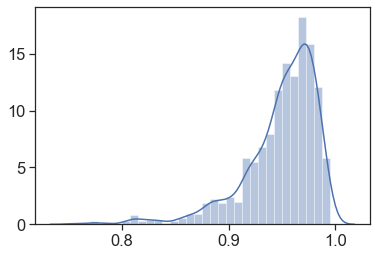

In [1338]:
score = []
for _ in range(1000):
    #what does this mean?
    cca = CCA(numCC=NUM_CC,reg=REG_COEF,verbose=False)
    D2_shuff = D2[np.random.permutation(np.arange(n_timepoints))]
    out = cca.train([D1,D2_shuff])
    x_ = np.sort(cca.cancorrs)[::-1]
    score.append(x_[:6])
seaborn.distplot(np.array(score)[:,0])

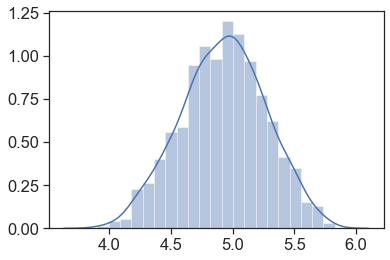

In [1328]:
seaborn.distplot(score)

In [1329]:
np.array(a).shape

(120,)

In [1330]:
np.array(b).shape

(120,)

In [1331]:
cca.cancorrs

array([0.92767258, 0.84727193, 0.84454408, 0.68104548, 0.68251466,
       0.79162117, 0.91592039, 0.87522307])

In [1332]:
import scipy.stats as stt

Training CCA, kernel = linear, regularization = 1.0000, 8 components
Percentile: 0.0
True score: 2.8771676438434763


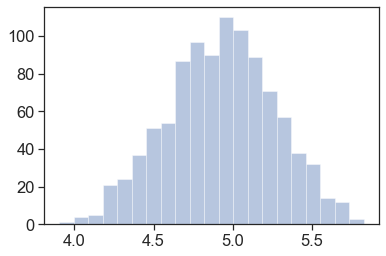

In [1333]:
cca = CCA(numCC=NUM_CC,reg=REG_COEF)
out = cca.train([D1,D2])
#true_score = explained_variance_score(D1.T,a[0].T,multioutput='uniform_average')
#x_ =get_explained_variance(D1,a[0])
#x2_ =get_explained_variance(D2,a[1])

true_score = np.sort(cca.cancorrs)[::-1][:3].sum()
#true_score = x_+x2_#get_explained_variance(D1,a)
seaborn.distplot(score,kde=0)
print('Percentile:',stt.percentileofscore(score,true_score))
print('True score:', true_score)

In [875]:
cca.cancorrs

array([0.99104037, 0.98129904, 0.97472013, 0.97261   , 0.96874875,
       0.97026574, 0.97558496, 0.97558046])

In [115]:
cca.ws[0].shape

(6, 8)

In [116]:
D1.shape


(9, 6)

In [117]:
np.array(cca.ws)[0].T.dot(D1.T)[0]

array([  72.12311497,  165.20611388,    8.83255818, -121.38217999,
        -51.86511731,   43.41143371,  375.78818835,   62.06033331,
       -554.17444509])

In [118]:
np.array(cca.ws)[1].T.dot(D2.T)[0]

array([  62.06033331,  375.78818835,   43.41143371,  -51.86511731,
       -121.38217999,    8.83255818,  165.20611388,   72.12311497,
       -554.17444509])

In [119]:
plt.plot(a[0][0])
plt.plot(D1[0])

NameError: name 'a' is not defined

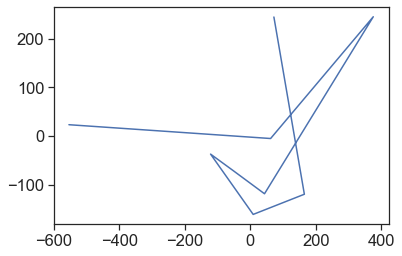

In [120]:
#this is number o
plt.plot(np.array(cca.ws)[0].T.dot(D1.T)[0],(np.array(cca.ws)[0].T.dot(D1.T)[3]))

In [2330]:
np.array(cca.ws)[0].T.dot(D1.T).shape

(4, 9)

In [2331]:
#np.linalg.eig(cca.ws[0])

In [2304]:
cca.comps[0].shape


(9, 4)

# Run da model 

In [2140]:
train1.shape

(500, 4)

In [2229]:
U1,S1,Vt1 = np.linalg.svd(D1.T)
S1 = np.eye(len(U1),len(Vt1))*S1[None]
U2,S2,Vt2 = np.linalg.svd(D2.T)
S2 = np.eye(len(U2),len(Vt2))*S2[None]


In [2230]:
np.eye(len(U1),len(Vt1)).shape

(120, 9)

In [2231]:
D1.shape

(9, 120)

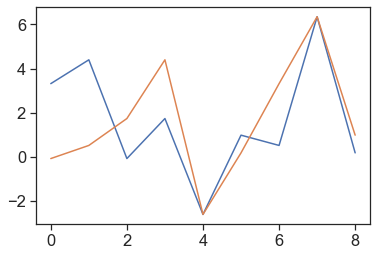

In [2232]:
plt.plot(D1[:,0])
plt.plot(D2[:,0])
#plt.xlim(0,50)

In [2285]:
hat_dims = 4

Uhat1 = U1[:,:hat_dims]
Uhat2 = U2[:,:hat_dims]

In [2286]:
I1= Uhat1.T.dot(U1)

In [2287]:
L1 = Uhat1.T.dot(D1.T)
L2 = Uhat2.T.dot(D2.T)

In [2288]:
#test1
#np.allclose(Uhat1.T.dot(D1),(np.dot(I1,S1.dot(Vt1))))

In [2289]:
#L = np.dot(Uhat1,Uhat1.T).dot(S1).dot(Vt1)
Q1,R1 = Vt1[:hat_dims].T,S1[:hat_dims,:hat_dims]
Q2,R2 = Vt2[:hat_dims].T,S2[:hat_dims,:hat_dims]

In [2290]:
#R1[np.abs(R1)<1e-5] = 0
#R2[np.abs(R2)<1e-5] = 0

In [2291]:
#Ub and Vtb are rotation matrices
Ub,Sb,Vtb = np.linalg.svd(np.dot(Q1.T,Q2))

In [2292]:
#These are rotation matricesb

M1 = np.linalg.pinv(R1).dot(Ub)
M2 = np.linalg.pinv(R2).dot(Vtb)

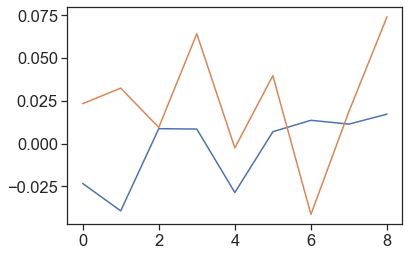

In [2293]:
#yes
plt.plot(np.dot(M1,L1)[0])
plt.plot(np.dot(M2,L2)[0])

In [2294]:
np.max(Ub)

0.6886649290757748

In [2295]:
for i in range(hat_dims):
    print(i,np.corrcoef(np.dot(M1,L1)[i],np.dot(M2,L2)[i])[0,1])
#print(np.corrcoef(np.dot(M1,L1)[1],np.dot(M2,L2)[1])[0,1])


0 0.11582188530411178
1 0.5809357598515644
2 0.2927080373057171
3 -0.004846060267381546


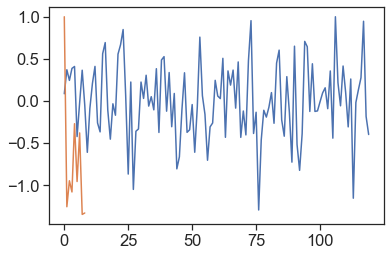

In [2296]:
pred = np.dot(Uhat1,np.dot(M1,L1))
plt.plot(pred[:,0]/np.max(pred[:,0]))
plt.plot(D1[:,0]/np.max(D1[:,0]))

In [2297]:
Uhat1.shape

(120, 4)

In [2298]:
D1.shape

(9, 120)

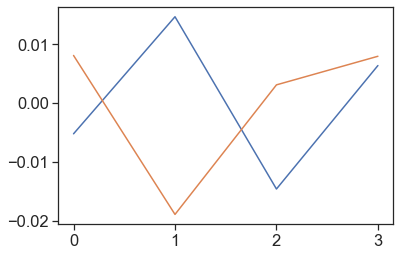

In [2299]:
plt.plot(np.dot(np.linalg.pinv(R1.T),Ub)[0])
plt.plot(-np.dot(np.linalg.pinv(R2.T),Vtb.T)[0])

In [2300]:
D1.shape

(9, 120)

In [2301]:
cca.cancorrs

array([1.        , 1.        , 1.        , 0.99999999])

In [2302]:
cca.validate([D1.T,D1.T])

ValueError: shapes (120,9) and (120,4) not aligned: 9 (dim 1) != 120 (dim 0)

In [1951]:
D1.T.shape

(9, 120)

In [1938]:
ev = np.array(cca.compute_ev([D1.T])[0])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3
Computing explained variance for component #4
Computing explained variance for component #5
Computing explained variance for component #6
Computing explained variance for component #7
Computing explained variance for component #8


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:323: RuntimeWarning: Mean of empty slice.


In [1940]:
ev.shape

array([[0.55352591, 0.55921632, 0.59683415, 0.46314613, 0.65806167,
        0.70867556, 0.65838612, 0.56034487, 0.48154395, 0.60718083,
        0.57498109, 0.75336433, 0.38091212, 0.52508027, 0.52789994,
        0.79958425, 0.64041348, 0.59667146, 0.67515369, 0.56831389,
        0.66695742, 0.61646598, 0.57274004, 0.62857176, 0.48136032,
        0.68783618, 0.63820597, 0.45209588, 0.58559216, 0.61162058,
        0.48937128, 0.62640231, 0.68481402, 0.63253005, 0.67429933,
        0.75625301, 0.49853385, 0.77844453, 0.76497971, 0.47329665,
        0.69882827, 0.52856314, 0.67194083, 0.61664985, 0.57179818,
        0.63625543, 0.60344336, 0.5172559 , 0.60725743, 0.40989532,
        0.74222187, 0.48915248, 0.49109679, 0.70009794, 0.62029211,
        0.69915518, 0.69505176, 0.70934988, 0.67756274, 0.58921132,
        0.57215353, 0.71462937, 0.62462931, 0.67670425, 0.47638491,
        0.58182394, 0.7066341 , 0.63453412, 0.5696355 , 0.58341612,
        0.57700701, 0.67060817, 0.73000103, 0.61

In [1946]:
# Imports
import numpy as np
#import rcca

# Initialize number of samples
nSamples = 1000

# Define two latent variables (number of samples x 1)
latvar1 = np.random.randn(nSamples,)
latvar2 = np.random.randn(nSamples,)

# Define independent components for each dataset (number of observations x dataset dimensions)
indep1 = np.random.randn(nSamples, 4)
indep2 = np.random.randn(nSamples, 5)

# Create two datasets, with each dimension composed as a sum of 75% one of the latent variables and 25% independent component
data1 = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
data2 = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T

# Split each dataset into two halves: training set and test set
train1 = data1[:nSamples//2]
train2 = data2[:nSamples//2]
test1 = data1[nSamples//2:]
test2 = data2[nSamples//2:]

In [1953]:
np.vstack((latvar1, latvar2, latvar1, latvar2)).shape

(4, 1000)

In [1947]:
train1.shape

(500, 4)

In [1948]:
train2.shape

(500, 5)

In [1949]:
test1.shape

(500, 4)

In [1950]:
test2.shape

(500, 5)